In [3]:
#Installing libraries
!pip3 install split-folders
!pip3 install keras-efficientnet
!pip3 install -U efficientnet
!pip3 install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [2]:
# Importing libraries
import pandas as pd
import numpy as np

import os
import shutil

import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

colab = False
kaggle = True

In [4]:
if colab :
  from google.colab import drive

  # Mount Google Drive
  drive.mount('/content/drive')

In [4]:
if colab:
    train_csv = pd.read_csv("/content/drive/MyDrive/hackathon/train/train.csv")
    test_csv =  pd.read_csv("/content/drive/MyDrive/hackathon/test/test.csv")
elif kaggle:
    train_csv = pd.read_csv("/kaggle/input/dataset/train/train.csv")
    test_csv =  pd.read_csv("/kaggle/input/dataset/test/test.csv")
else:
    train_csv = pd.read_csv("./train/train.csv")
    test_csv =  pd.read_csv("./test/test.csv")

labels = {1:'crack',2:'scratch',3:'tire flat',4 :'dent', 5: 'glass shatter', 6: 'lamp broken'}

In [5]:
# Checking number of records
print(f"{train_csv.shape=}")
print(f"{test_csv.shape=}")

train_csv.shape=(7200, 3)
test_csv.shape=(4800, 2)


In [6]:
# Lets have a look at csv file
train_csv.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [7]:
train_csv.dtypes

image_id     int64
filename    object
label        int64
dtype: object

In [8]:
# Let us see number of data points for each labels
train_csv['label'].value_counts()


label
2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: count, dtype: int64

In [9]:
# Define image folder path
if colab:
    path_to_train_images = "/content/drive/MyDrive/hackathon/train/images/"
    path_to_test_images = "/content/drive/MyDrive/hackathon/test/images/"
elif kaggle:
    path_to_train_images = "/kaggle/input/dataset/train/images/"
    path_to_test_images = "/kaggle/input/dataset/test/images/"
else:
    path_to_train_images = "./train/images/"
    path_to_test_images = "./test/images/"

# Listing all images
train_image_files = os.listdir(path_to_train_images)
#test_image_files = os.listdir(path_to_test_images)

train_image_files = [t for t in train_image_files if t.endswith(".jpg")]
train_image_files=[t for t in train_image_files if '(' not in t]

In [10]:
# print(f"{train_image_files=}")
# print(f"{test_image_files=}")
#len(set(train_image_files))

In [11]:

# # Check some images of train

# for i,image_file in enumerate(train_image_files):
#     if image_file.endswith(".jpg") or image_file.endswith(".png"):
#         if i < 5:
#             print('Labels : ' , f"{labels[int(train_csv.loc[train_csv['filename'] == image_file]['label'])]}")

#             image = Image.open(path_to_train_images + image_file)
#             display(image)

#             print("-"*50)

#         else:
#             break

In [12]:
# # Let us find the maximum height and maximum weight in all images
# train_max_width = -float('inf')
# train_max_height = -float('inf')

# train_min_width = float('inf')
# train_min_height = float('inf')


# for image_file in train_image_files:
#     if image_file.endswith(".jpg") or image_file.endswith(".png"):
#         image = Image.open(path_to_train_images + image_file)

#         width, height = image.size

#         train_max_height = max(height,train_max_height)
#         train_max_width = max(width,train_max_width)

#         train_min_width = min(height,train_max_height)
#         train_min_height = min(height,train_max_height)

# print(f"{train_max_height=}")

# print(f"{train_max_width=}")

# print(f"{train_min_height=}")

# print(f"{train_min_width=}")

In [13]:
labels = {1:'crack',2:'scratch',3:'tire flat',4 :'dent', 5: 'glass shatter', 6: 'lamp broken'}
folder = './dataset/train'
train_image_files=[t for t in train_image_files if '(' not in t]

#making folder for each classes
for values in labels:
    path = os.path.join(folder,str(values))
    os.makedirs(path,exist_ok=True)

# coping our raw data to each classes

for image in train_image_files:
 #   print(image)
    label = int((train_csv[train_csv['filename'] == image]['label']).iloc[0])
  #  print(label)
  #  path = os.path.join(folder,label,'/')
    from_path = os.path.join(path_to_train_images,image)
    to_path = os.path.join(folder,str(label))
    if not os.path.exists(os.path.join(to_path,image)):
      shutil.copy(from_path,to_path)


In [14]:

import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("./dataset/train", output="./dataset_final",
    seed=1337, ratio=(.8, .2, ), group_prefix=None, move=True) # default values


Copying files: 7200 files [00:00, 15228.90 files/s]


In [15]:
from tensorflow.keras.applications import EfficientNetB7

In [16]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
IMG_SIZE = 600
batch = 32

In [17]:
# Add our data-augmentation parameters to ImageDataGenerator

train_dir = './dataset_final/train'
validation_dir = './dataset_final/val'


train_datagen = ImageDataGenerator()#rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

valid_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(train_dir, batch_size = batch, class_mode = 'categorical', target_size = (IMG_SIZE , IMG_SIZE ))

validation_generator = valid_datagen.flow_from_directory( validation_dir, batch_size = batch, class_mode = 'categorical', target_size = (IMG_SIZE, IMG_SIZE))



Found 5758 images belonging to 6 classes.
Found 1442 images belonging to 6 classes.


In [18]:
import keras
from keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-1)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [25]:
NUM_CLASSES = 6
model = build_model(num_classes=NUM_CLASSES)



In [26]:
#checkpoint_filepath = './ckpt/checkpoint.weights.h5'
# include the epoch in the file name. (use `str.format`)
checkpoint_path = './training_2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [49]:
# model.save('/content/models')

In [28]:
epochs = 10
hist = model.fit(train_generator, steps_per_epoch = 40,
                 epochs=epochs, validation_data=validation_generator, callbacks=[model_checkpoint_callback])

Epoch 1/10


2023-12-01 18:37:02.862732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 [==============================] - 266s 6s/step - loss: 21.8579 - accuracy: 0.5454 - val_loss: 19.5945 - val_accuracy: 0.4730
Epoch 2/10
40/40 [==============================] - 235s 6s/step - loss: 16.3299 - accuracy: 0.6562 - val_loss: 15.4937 - val_accuracy: 0.4813
Epoch 3/10
40/40 [==============================] - 233s 6s/step - loss: 14.7876 - accuracy: 0.6859 - val_loss: 23.3410 - val_accuracy: 0.3793
Epoch 4/10
40/40 [==============================] - 235s 6s/step - loss: 15.6710 - accuracy: 0.6820 - val_loss: 18.9664 - val_accuracy: 0.5492
Epoch 5/10
40/40 [==============================] - 235s 6s/step - loss: 14.0817 - accuracy: 0.7016 - val_loss: 13.5424 - val_accuracy: 0.5513
Epoch 6/10
40/40 [==============================] - 233s 6s/step - loss: 17.6204 - accuracy: 0.6664 - val_loss: 31.1106 - val_accuracy: 0.5277
Epoch 7/10
40/40 [==============================] - 235s 6s/step - loss: 16.2106 - accuracy: 0.7008 - val_loss: 15.7465 - val_accuracy: 0.6103
Epoch 8/10

In [29]:
model.save('./content/models')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [59]:
def unfreeze_model(model):
    # We unfreeze the top 5 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)



In [ ]:
epochs = 2
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator,callbacks=[model_checkpoint_callback])


Epoch 1/2


2023-12-01 20:30:12.357297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


180/180 [==============================] - ETA: 0s - loss: 13.9780 - accuracy: 0.7336

In [32]:
model.save('./content2/models')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


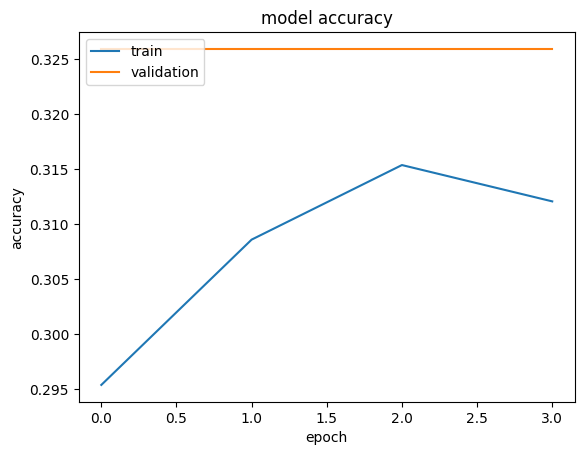

In [35]:

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(hist)

In [ ]:
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
#model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) can be loaded as -
model.load_weights(checkpoint_filepath)

In [54]:
if colab:
    test_dir = '/content/drive/MyDrive/hackathon/test'
elif kaggle:
    test_dir = "/kaggle/input/dataset/test/"
else:
    test_dir = './test/'
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory( test_dir, batch_size = 20, class_mode = None, target_size = (IMG_SIZE, IMG_SIZE))

test_generator.reset()


Found 4800 images belonging to 1 classes.


In [55]:
predictions = model.predict(test_generator)

predicted_class_indices=np.argmax(predictions,axis=1)
labels_map = (train_generator.class_indices)
labels_map = dict((v,k) for k,v in labels_map.items())
predictions = [labels_map[i] for i in predicted_class_indices]

240/240 [==============================] - 398s 2s/step


In [56]:
# Preparing submitssion file

filenames=test_generator.filenames
filenames = [f[7:-3] for f in filenames]
results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.to_csv("sub.csv",index=False)

In [57]:
len(filenames)

4800

In [58]:
set(predictions)

{'1', '2', '3', '4', '5', '6'}

In [18]:

from sklearn.metrics import f1_score
import numpy as np
import keras

class DataCallback(keras.callbacks.Callback):  # diff
    """Callback to operate on batch data from metric."""

    def __init__(self):
        """Offer a metric to access batch data."""
        super().__init__()

        self.y_true = None
        self.y_pred = None
        #self.metric = tf.keras.metrics.F1Score(threshold=0.5)


    def set_model(self, model):
        """Initialize variables when model is set."""
        self.y_true = tf_nan(model.output.dtype)
        self.y_pred = tf_nan(model.output.dtype)

    def metric(self, y_true, y_pred):

        print(y_true,y_pred)
        """Fake metric."""
        if self.y_true is None:
          self.y_true.assign(y_true)
          self.y_pred.assign(y_pred)
        else:
          self.y_true = tf.concat([self.y_true,y_true],axis=0)
          self.y_pred = tf.concat([self.y_pred,y_pred],axis=0)

        def create_one_hot_array(y_pred):
        # Get the indices of the maximum values along each row
          max_indices = np.argmax(y_pred, axis=1)

          # Create a new array with zeros
          one_hot_array = np.zeros_like(y_pred)

          # Set 1 at the maximum value indices
          one_hot_array[np.arange(len(y_pred)), max_indices] = 1

          return one_hot_array

             #   _logs ['f1_Score'] = metric
        # print("y_true =", y_true.numpy().shape)
        # print("y_pred =", y_pred.numpy().shape)

        score = f1_score(self.y_true.numpy(),create_one_hot_array(self.y_pred.numpy()),average='macro')
        #metric.update_state(y_true.nump
        return score

    def on_epoch_end(self, _batch, logs=None):
        """See keras.callbacks.Callback.on_train_batch_end."""


        def create_one_hot_array(y_pred):
        # Get the indices of the maximum values along each row
          max_indices = np.argmax(y_pred, axis=1)

          # Create a new array with zeros
          one_hot_array = np.zeros_like(y_pred)

          # Set 1 at the maximum value indices
          one_hot_array[np.arange(len(y_pred)), max_indices] = 1

          return one_hot_array

             #   _logs ['f1_Score'] = metric
        print("y_true =", self.y_true.numpy().shape)
        print("y_pred =", self.y_pred.numpy().shape)

        score = f1_score(self.y_true.numpy(),create_one_hot_array(self.y_pred.numpy()),average='macro')
        #metric.update_state(y_true.nump(), y_pred.numpy())
        #result = metric.result()
       # logs['f1_score'] = score
        print('f1_score')
        #return logs
        #print
        del self.y_true, self.y_pred



    # def on_epoch_end(self, _logs=None):
    #     """Clean up."""
    #     del self.y_true, self.y_pred

def tf_nan(dtype):
  """Create NaN variable of proper dtype and variable shape for assign()."""
  return tf.Variable(float("nan"), dtype=dtype, shape=tf.TensorShape(None))
callback = DataCallback()

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Create the EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
base_model.trainable = False

# Flatten the output
x = Flatten()(base_model.output)

# Add additional layers on top of the flattened output
x = Dense(1028, activation='relu')(x)

# Output layer
output = Dense(6, activation='softmax')(x)

# Create the full model
full_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
full_model.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['categorical_accuracy',callback.metric])



16705208/16705208 [==============================] - 0s 0us/step


In [20]:
no_epochs = 8
full_model.fit(train_generator,steps_per_epoch=3, validation_data = validation_generator,
                             epochs = no_epochs, callbacks=[callback])
#model.save("tmp.tf")


Epoch 1/8

Tensor("IteratorGetNext:1", shape=(None, None), dtype=float32) Tensor("model/dense_1/Softmax:0", shape=(None, 6), dtype=float32)


AttributeError: ignored

In [87]:
if colab:
  test_dir = '/content/drive/MyDrive/hackathon/test'
else:
  test_dir = './test/'
test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory( test_dir, batch_size = 20, class_mode = None, target_size = (224, 224))

test_generator.reset()


Found 4800 images belonging to 1 classes.


## SUBMITING OUR PREDICTIONS

In [ ]:
predictions = full_model.predict(test_generator)

predicted_class_indices=np.argmax(predictions,axis=1)
labels_map = (train_generator.class_indices)
labels_map = dict((v,k) for k,v in labels_map.items())
predictions = [labels_map[i] for i in predicted_class_indices]

#print(predictions)

In [89]:
# Preparing submitssion file

filenames=test_generator.filenames
filenames = [f[7:] for f in filenames]
results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.to_csv("sub.csv",index=False)


In [ ]:
(train_generator.class_indices)

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}

In [16]:
# import shutil

# shutil.rmtree('/content/dataset')

# shutil.rmtree('/content/dataset_final')

In [92]:
len( base_model.layers)


238

In [ ]:
for layers in base_model.layers:
  print (layers)

In [62]:

from sklearn.metrics import f1_score
import numpy as np
import keras

class DataCallback(keras.callbacks.Callback):  # diff
    """Callback to operate on batch data from metric."""

    def __init__(self):
        """Offer a metric to access batch data."""
        super().__init__()

        self.y_true = None
        self.y_pred = None
        #self.metric = tf.keras.metrics.F1Score(threshold=0.5)


    def set_model(self, model):
        """Initialize variables when model is set."""
        self.y_true = tf_nan(model.output.dtype)
        self.y_pred = tf_nan(model.output.dtype)

    def metric(self, y_true, y_pred):

        print(y_true,y_pred)
        """Fake metric."""
        if self.y_true is None:
          self.y_true.assign(y_true)
          self.y_pred.assign(y_pred)
        else:
          self.y_true = tf.concat([self.y_true,y_true],axis=0)
          self.y_pred = tf.concat([self.y_pred,y_pred],axis=0)

        def create_one_hot_array(y_pred):
        # Get the indices of the maximum values along each row
          max_indices = np.argmax(y_pred, axis=1)

          # Create a new array with zeros
          one_hot_array = np.zeros_like(y_pred)

          # Set 1 at the maximum value indices
          one_hot_array[np.arange(len(y_pred)), max_indices] = 1

          return one_hot_array

             #   _logs ['f1_Score'] = metric
        # print("y_true =", y_true.numpy().shape)
        # print("y_pred =", y_pred.numpy().shape)

        score = f1_score(y_true.numpy(),create_one_hot_array(y_pred.numpy()),average='macro')
        #metric.update_state(y_true.nump
        return score

    def on_epoch_end(self, _batch, logs=None):
        """See keras.callbacks.Callback.on_train_batch_end."""


        def create_one_hot_array(y_pred):
        # Get the indices of the maximum values along each row
          max_indices = np.argmax(y_pred, axis=1)

          # Create a new array with zeros
          one_hot_array = np.zeros_like(y_pred)

          # Set 1 at the maximum value indices
          one_hot_array[np.arange(len(y_pred)), max_indices] = 1

          return one_hot_array

             #   _logs ['f1_Score'] = metric
        print("y_true =", self.y_true.numpy().shape)
        print("y_pred =", self.y_pred.numpy().shape)

        score = f1_score(self.y_true.numpy(),create_one_hot_array(self.y_pred.numpy()),average='macro')
        #metric.update_state(y_true.nump(), y_pred.numpy())
        #result = metric.result()
       # logs['f1_score'] = score
        print('f1_score')
        #return logs
        #print
        del self.y_true, self.y_pred



    # def on_epoch_end(self, _logs=None):
    #     """Clean up."""
    #     del self.y_true, self.y_pred

def tf_nan(dtype):
  """Create NaN variable of proper dtype and variable shape for assign()."""
  return tf.Variable(float("nan"), dtype=dtype, shape=tf.TensorShape(None))
callback = DataCallback()